# Installation and Setup

In [ ]:
# Pyspark
!pip install pyspark
!PYSPARK_HADOOP_VERSION=3 pip install pyspark
!PYSPARK_HADOOP_VERSION=3 pip install pyspark -v
!pip install pyspark-connect

In [ ]:
!pip install polars
!pip install pandas
!pip install matplotlib
!pip install mplfinance
!pip install seaborn
!pip install scikit-learn
!pip install xgboost

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Start spark session
spark = SparkSession.builder.appName("Bitcoin_DataAnalysis").getOrCreate()

# try:
#     spark.stop()
# except:
#     pass

# Benchmark Pandas v/s Polars v/s Pyspark

In [ ]:
import pandas as pd
import polars as pl
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, from_unixtime, year, mean as Fmean
import matplotlib.pyplot as plt
import time

class DataFrameLoader:
    """
    A versatile loader for CSV datasets supporting Pandas, Polars, and PySpark.

    Features:
    ---------
    - Load CSV files into Pandas, Polars, or PySpark DataFrames
    - Ensures 'Timestamp' column remains as epoch seconds
    - Provides simple benchmarking of common operations across libraries
    """

    def __init__(self, csv_path):
        """
        Initialize the DataFrameLoader.

        Parameters:
        -----------
        csv_path : str
            Path to the CSV file to be loaded.
        """
        self.csv_path = csv_path

        # Try to initialize a Spark session for PySpark support
        try:
            self.spark = SparkSession.builder.appName("DataFrameLoader").getOrCreate()
        except:
            # If Spark initialization fails, PySpark operations will raise an error
            self.spark = None

    def load(self, library='pandas'):
        """
        Load the CSV file into the specified library's DataFrame.

        Parameters:
        -----------
        library : str
            Choose 'pandas', 'polars', or 'pyspark'.

        Returns:
        --------
        DataFrame in the chosen library format
        """
        library = library.lower()

        if library == 'pandas':
            # Read CSV using pandas
            df = pd.read_csv(self.csv_path)
            # Keep Timestamp column as epoch seconds (int)
            return df

        elif library == 'polars':
            # Read CSV using Polars
            df = pl.read_csv(self.csv_path)
            # Ensure Timestamp column is Int64 for consistency
            if "Timestamp" in df.columns and df["Timestamp"].dtype not in [pl.Int64, pl.Float64]:
                df = df.with_columns(pl.col("Timestamp").cast(pl.Int64))
            return df

        elif library == 'pyspark':
            # Ensure Spark session exists
            if self.spark is None:
                raise ValueError("Spark session not initialized")
            df = self.spark.read.csv(self.csv_path, header=True, inferSchema=True)
            # Cast Timestamp to long for epoch seconds consistency
            if "Timestamp" in df.columns:
                df = df.withColumn("Timestamp", col("Timestamp").cast("long"))
            return df

        else:
            raise ValueError("Unsupported library. Choose 'pandas', 'polars', or 'pyspark'.")

    def benchmark(self):
        """
        Benchmark CSV reading and basic operations across Pandas, Polars, and PySpark.

        Operations Benchmarked:
        -----------------------
        - read: CSV reading time
        - head: Fetching first rows
        - filter: Filtering Close price > 50,000
        - groupby_mean: Group by year and compute mean Close price

        Returns:
        --------
        timings : dict
            Dictionary of timing results for each library and operation
        """
        libraries = ['pandas', 'polars', 'pyspark']
        timings = {lib: {} for lib in libraries}

        for lib in libraries:
            # ---------- 1. Read CSV ----------
            start = time.time()
            df = self.load(lib)
            timings[lib]['read'] = time.time() - start

            # ---------- 2. Fetch head ----------
            start = time.time()
            if lib == 'pyspark':
                # Spark action required to trigger execution
                df.show(5, truncate=False)
            else:
                # Pandas/Polars head fetch
                df.head()
            timings[lib]['head'] = time.time() - start

            # ---------- 3. Filter ----------
            start = time.time()
            if lib == 'pandas':
                _ = df[df['Close'] > 50000]
            elif lib == 'polars':
                _ = df.filter(pl.col("Close") > 50000)
            elif lib == 'pyspark':
                _ = df.filter(df["Close"] > 50000).count()  # Spark requires action
            timings[lib]['filter'] = time.time() - start

            # ---------- 4. GroupBy Year and Compute Mean ----------
            start = time.time()
            if 'Timestamp' in df.columns:
                if lib == 'pandas':
                    # Convert epoch seconds to year on the fly
                    df['Year'] = pd.to_datetime(df['Timestamp'], unit='s').dt.year
                    _ = df.groupby('Year')['Close'].mean()
                elif lib == 'polars':
                    # Approximate year: seconds since 1970 / 31556952 + 1970
                    df = df.with_columns(
                        ((pl.col("Timestamp") / 31556952 + 1970).cast(pl.Int64)).alias("Year")
                    )
                    _ = df.group_by("Year").agg(pl.mean("Close"))
                elif lib == 'pyspark':
                    # Use Spark SQL functions to extract year and compute mean
                    df = df.withColumn("Year", year(from_unixtime(col("Timestamp"))))
                    _ = df.groupBy("Year").agg(Fmean("Close"))
            timings[lib]['groupby_mean'] = time.time() - start

        # ---------- 5. Plot Benchmark ----------
        ops = ['read', 'head', 'filter', 'groupby_mean']
        x = range(len(libraries))
        plt.figure(figsize=(12,6))

        # Plot each operation as a separate bar
        for idx, op in enumerate(ops):
            times = [timings[lib][op] for lib in libraries]
            plt.bar([i + idx*0.2 for i in x], times, width=0.2, label=op)

        plt.xticks([i + 0.3 for i in x], libraries)
        plt.ylabel('Time (seconds)')
        plt.title('CSV Benchmark: Pandas vs Polars vs PySpark (Epoch Timestamp)')
        plt.legend()
        plt.show()

        return timings


# ------------------------
# Example Usage
# ------------------------
csv_file_path = "btcusd_1-min_data.csv"
loader = DataFrameLoader(csv_file_path)
'''
# Load Pandas DataFrame
df_pd = loader.load('pandas')

# Load Polars DataFrame
df_pl = loader.load('polars')

# Load PySpark DataFrame
df_spark = loader.load('pyspark')
'''
# Benchmark performance
timings = loader.benchmark()

### For a dataset of approximately 350MB, the overhead of PySpark is not justified. In fact, Polars and even Pandas outperform PySpark in terms of speed. Detailed explanations and benchmarks can be found in the README.

+----------+----+----+----+-----+------+
|Timestamp |Open|High|Low |Close|Volume|
+----------+----+----+----+-----+------+
|1325412060|4.58|4.58|4.58|4.58 |0.0   |
|1325412120|4.58|4.58|4.58|4.58 |0.0   |
|1325412180|4.58|4.58|4.58|4.58 |0.0   |
|1325412240|4.58|4.58|4.58|4.58 |0.0   |
|1325412300|4.58|4.58|4.58|4.58 |0.0   |
+----------+----+----+----+-----+------+
only showing top 5 rows


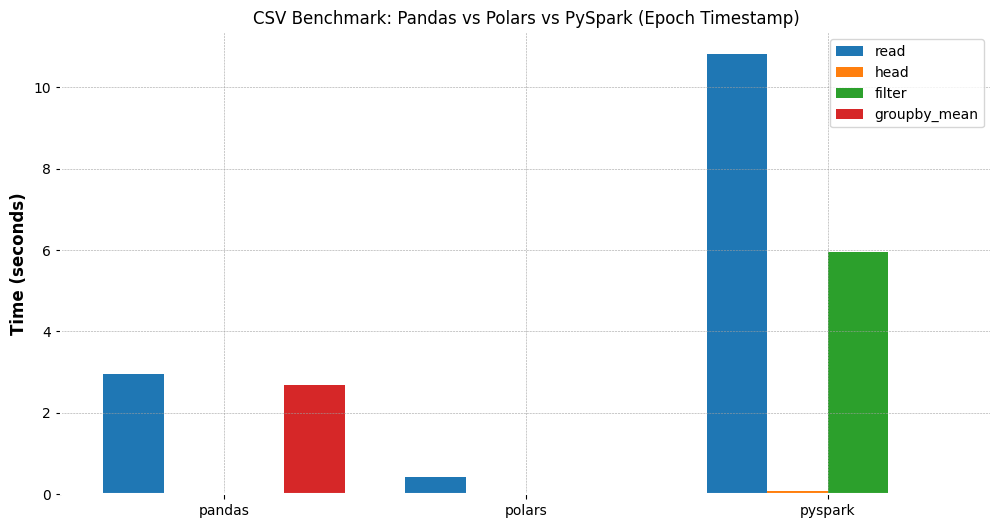

Benchmark results (in seconds):
pandas {'read': 2.9465601444244385, 'head': 0.00018596649169921875, 'filter': 0.03913307189941406, 'groupby_mean': 2.677454948425293}
polars {'read': 0.41265392303466797, 'head': 6.389617919921875e-05, 'filter': 0.007007122039794922, 'groupby_mean': 0.03651690483093262}
pyspark {'read': 10.807034015655518, 'head': 0.07787418365478516, 'filter': 5.950787782669067, 'groupby_mean': 0.006757259368896484}


In [ ]:
# BENCHMARK
benchmark_results = loader.benchmark()
print("Benchmark results (in seconds):")
for lib, results in benchmark_results.items():
    print(lib, results)

# Exploratory Data Analysis

In [ ]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import mplfinance as mpf

class CryptoEDA:
    """
    Perform exploratory data analysis (EDA) on cryptocurrency OHLCV (Open, High, Low, Close, Volume) data.

    Features:
    ----------
    - Overview of data (shape, statistics)
    - Price trend plots (full history or last X seconds)
    - Volume trend plots
    - Returns calculation and distribution
    - Rolling volatility calculation and plot
    - Correlation heatmap of key numerical columns
    - Candlestick chart preview for last N rows
    """

    def __init__(self, df: pl.DataFrame):
        """
        Initialize the EDA class.

        Parameters:
        -----------
        df : pl.DataFrame
            Input crypto OHLCV dataset. Must include 'Timestamp' column in epoch seconds.
        """
        # Store a clone to avoid modifying original dataframe
        self.df = df.clone()

        # Convert epoch seconds to datetime for plotting
        self.df = self.df.with_columns([
            (pl.col("Timestamp") * 1000).cast(pl.Datetime("ms")).alias("Timestamp_dt")
        ])

    # ------------------------
    # 1. Overview
    # ------------------------
    def overview(self):
        """
        Print basic overview of the dataset:
        - Number of rows and columns
        - Summary statistics (min, max, mean, etc.)
        """
        print("Data shape:", self.df.shape)
        print(self.df.describe())

    # ------------------------
    # 2. Price Trend
    # ------------------------
    def plot_price_trend(self, recent_seconds: int = None):
        """
        Plot Open and Close price over time.

        Parameters:
        -----------
        recent_seconds : int, optional
            If provided, plot only the last `recent_seconds` of data to focus on recent trends.
        """
        plt.figure(figsize=(15,5))

        df_plot = self.df
        if recent_seconds is not None:
            # Filter last N seconds
            window_time = self.df["Timestamp"].max()
            df_plot = self.df.filter(pl.col("Timestamp") > (window_time - recent_seconds))

        plt.plot(df_plot["Timestamp_dt"].to_numpy(), df_plot["Close"].to_numpy(),
                 label="Close Price", color="blue")
        plt.plot(df_plot["Timestamp_dt"].to_numpy(), df_plot["Open"].to_numpy(),
                 label="Open Price", color="orange", alpha=0.7)

        plt.xlabel("Time")
        plt.ylabel("Price (USD)")
        title = "Bitcoin Price Trend"
        if recent_seconds:
            title += f" (Last {recent_seconds} sec)"
        plt.title(title)
        plt.legend()
        plt.show()

    # ------------------------
    # 3. Volume Trend
    # ------------------------
    def plot_volume_trend(self):
        """
        Plot trading volume over time.
        """
        plt.figure(figsize=(15,5))
        plt.plot(self.df["Timestamp_dt"].to_numpy(), self.df["Volume"].to_numpy(),
                 color="green", alpha=0.6)
        plt.xlabel("Time")
        plt.ylabel("Volume (BTC)")
        plt.title("Bitcoin Trading Volume")
        plt.show()

    # ------------------------
    # 4. Returns
    # ------------------------
    def add_returns(self):
        """
        Compute simple percentage returns from Close prices:
        returns[t] = (Close[t] / Close[t-1]) - 1

        Returns:
        --------
        self : CryptoEDA
            Updated dataframe with 'returns' column
        """
        self.df = self.df.with_columns([
            (pl.col("Close").pct_change()).alias("returns")
        ])
        return self

    def plot_returns_distribution(self):
        """
        Plot histogram and KDE of returns to visualize distribution.
        """
        returns = self.df["returns"].to_numpy()
        plt.figure(figsize=(10,5))
        sns.histplot(returns, bins=100, kde=True, color="purple")
        plt.title("Distribution of Returns")
        plt.xlabel("Returns")
        plt.ylabel("Frequency")
        plt.show()

    # ------------------------
    # 5. Rolling Volatility
    # ------------------------
    def add_rolling_volatility(self, window: int = 60):
        """
        Compute rolling standard deviation of returns as volatility.

        Parameters:
        -----------
        window : int
            Rolling window size in seconds or periods
        """
        self.df = self.df.with_columns([
            pl.col("returns").rolling_std(window).alias(f"volatility_{window}s")
        ])
        return self

    def plot_rolling_volatility(self, window: int = 60):
        """
        Plot rolling volatility over time.

        Parameters:
        -----------
        window : int
            Rolling window size (must match `add_rolling_volatility`)
        """
        plt.figure(figsize=(15,5))
        plt.plot(self.df["Timestamp_dt"].to_numpy(), self.df[f"volatility_{window}s"].to_numpy(),
                 color="red")
        plt.title(f"Rolling {window}s Volatility")
        plt.xlabel("Time")
        plt.ylabel("Volatility")
        plt.show()

    # ------------------------
    # 6. Correlation Heatmap
    # ------------------------
    def plot_correlation_heatmap(self, columns=None):
        """
        Plot correlation matrix of selected numeric columns.

        Parameters:
        -----------
        columns : list of str, optional
            List of columns to include in correlation. Default is ["Open","High","Low","Close","Volume","returns"].
        """
        df_pandas = self.df.to_pandas()
        numeric_cols = columns or ["Open","High","Low","Close","Volume","returns"]
        corr = df_pandas[numeric_cols].corr()

        plt.figure(figsize=(8,6))
        sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
        plt.title("Correlation Heatmap")
        plt.show()

    # ------------------------
    # 7. Candlestick Chart
    # ------------------------
    def plot_candlestick(self, last_n: int = 50):
        """
        Plot last N candlesticks with volume using mplfinance.

        Parameters:
        -----------
        last_n : int
            Number of most recent candles to show
        """
        # Sort descending and take last N rows
        df_candle_pd = self.df.sort("Timestamp_dt", descending=True).head(last_n).to_pandas()
        df_candle_pd.set_index("Timestamp_dt", inplace=True)

        mpf.plot(
            df_candle_pd,
            type="candle",
            volume=True,
            style="charles",
            title=f"Last {last_n} Candles"
        )

    # ------------------------
    # 8. Run all EDA
    # ------------------------
    def run_all(self, recent_seconds: int = None, vol_window: int = 60, candlestick_rows: int = 50):
        """
        Convenience method to run all EDA steps in sequence.

        Parameters:
        -----------
        recent_seconds : int, optional
            Only show recent price trend (default None = full data)
        vol_window : int
            Window size for rolling volatility
        candlestick_rows : int
            Number of candlesticks to plot
        """
        self.overview()
        self.plot_price_trend(recent_seconds=recent_seconds)
        self.plot_volume_trend()
        self.add_returns()
        self.plot_returns_distribution()
        self.add_rolling_volatility(window=vol_window)
        self.plot_rolling_volatility(window=vol_window)
        self.plot_correlation_heatmap()
        self.plot_candlestick(last_n=candlestick_rows)


/Users/kedarvaidya/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


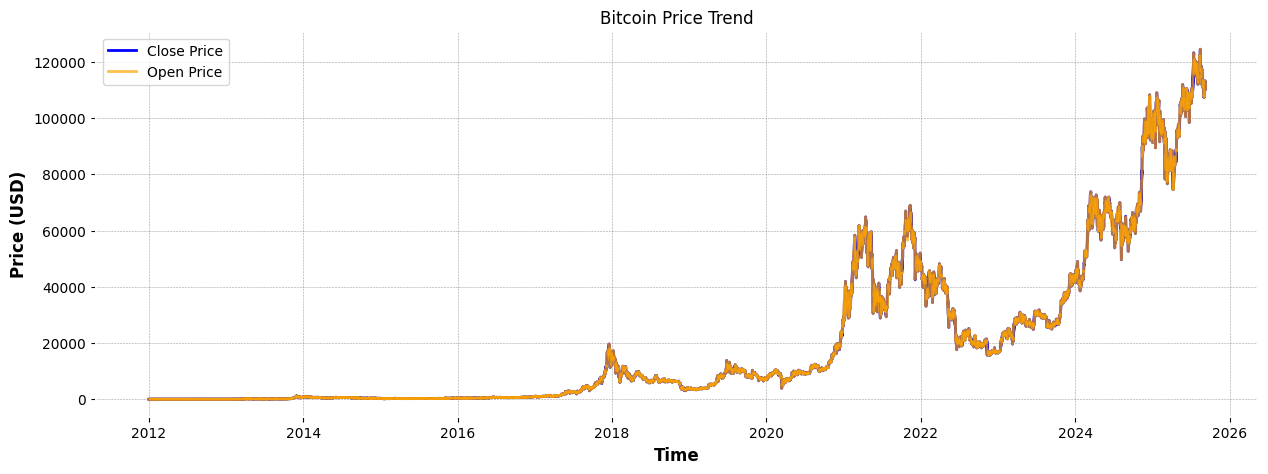

Data shape: (7196797, 7)
shape: (9, 8)
┌────────────┬────────────┬────────────┬───────────┬───────────┬───────────┬───────────┬───────────┐
│ statistic  ┆ Timestamp  ┆ Open       ┆ High      ┆ Low       ┆ Close     ┆ Volume    ┆ Timestamp │
│ ---        ┆ ---        ┆ ---        ┆ ---       ┆ ---       ┆ ---       ┆ ---       ┆ _dt       │
│ str        ┆ f64        ┆ f64        ┆ f64       ┆ f64       ┆ f64       ┆ f64       ┆ ---       │
│            ┆            ┆            ┆           ┆           ┆           ┆           ┆ str       │
╞════════════╪════════════╪════════════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ count      ┆ 7.196797e6 ┆ 7.196797e6 ┆ 7.196797e ┆ 7.196797e ┆ 7.196797e ┆ 7.196797e ┆ 7196797   │
│            ┆            ┆            ┆ 6         ┆ 6         ┆ 6         ┆ 6         ┆           │
│ null_count ┆ 0.0        ┆ 0.0        ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0         │
│ mean       ┆ 1.5413e9   ┆ 19795.1582 ┆ 19802.445 ┆

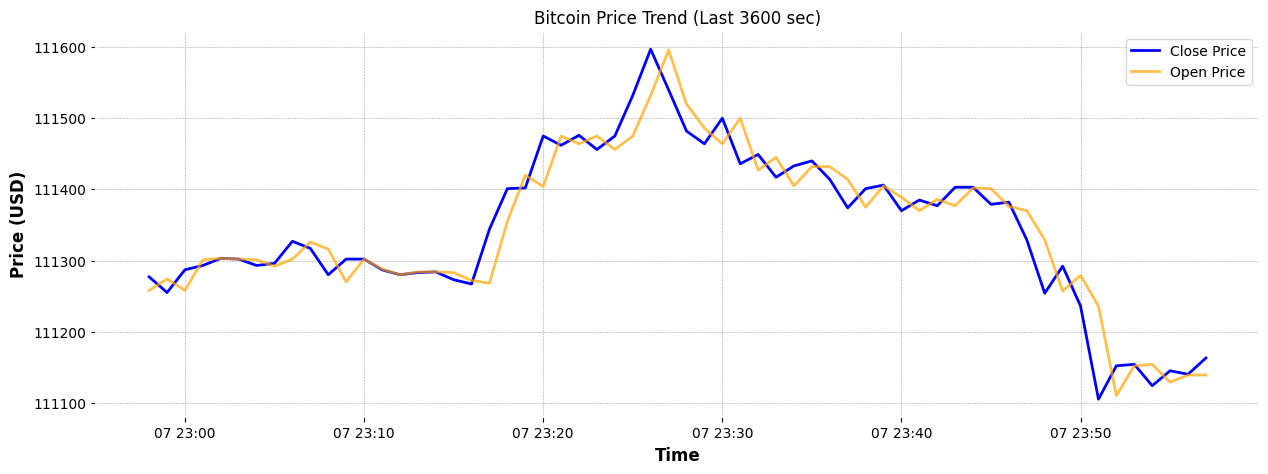

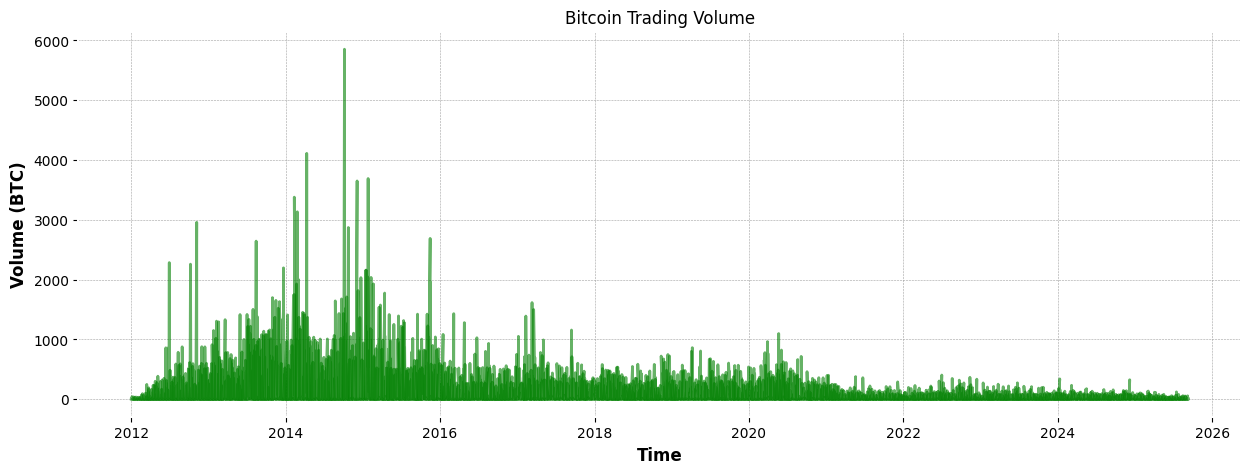

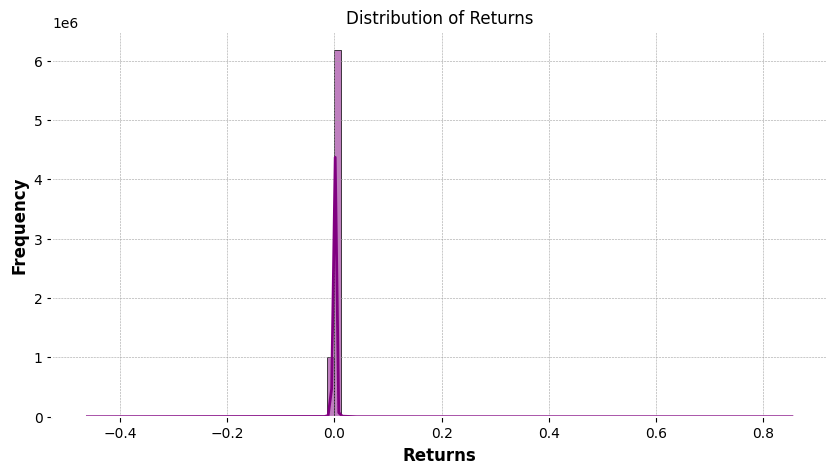

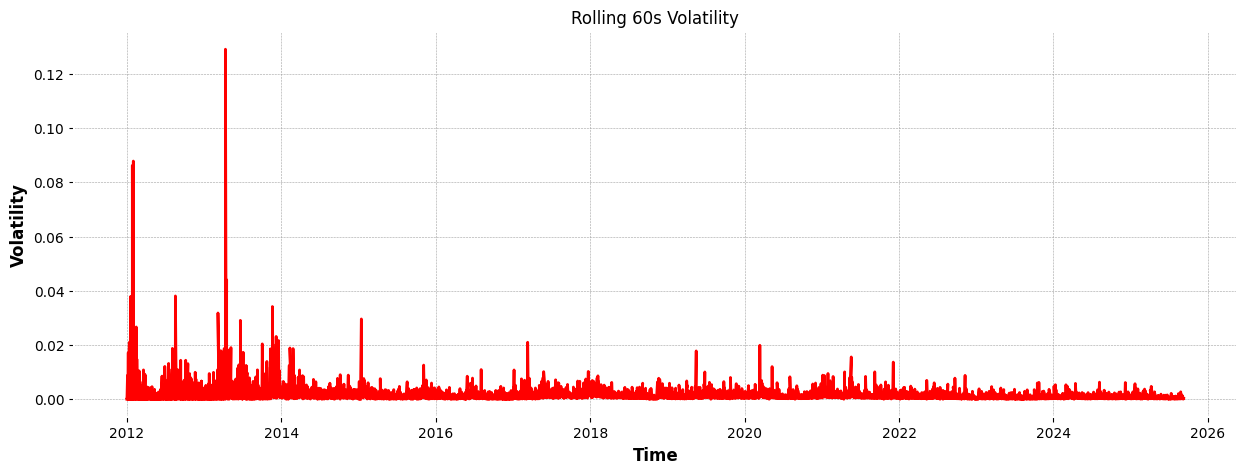

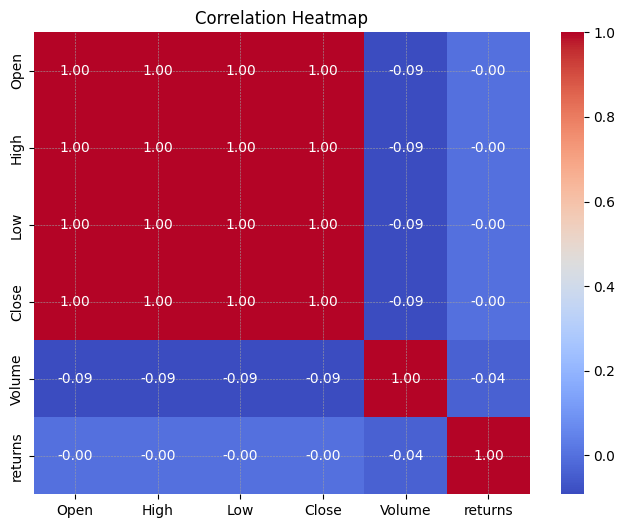

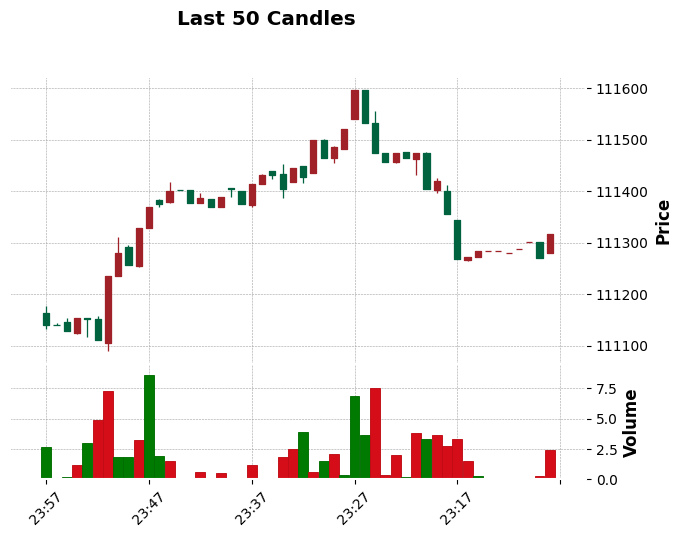

In [ ]:
df = loader.load('polars')

# df is your Polars DataFrame with OHLCV and Timestamp columns
eda = CryptoEDA(df)
eda.plot_price_trend()

# Run full EDA
eda.run_all(recent_seconds=3600, vol_window=60, candlestick_rows=50)

#  Or individual plots
'''
eda.plot_price_trend()
eda.plot_volume_trend()
eda.add_returns()
eda.plot_returns_distribution()
'''


# Feature Engineering

In [ ]:
class CryptoFeatureEngineer:
    """
    Feature engineering for cryptocurrency OHLCV (Open, High, Low, Close, Volume) data using Polars.
    
    Features added:
    1. Returns and spreads
    2. Lag features for previous periods
    3. Rolling statistics (SMA, EMA, volatility, ATR)
    4. RSI (Relative Strength Index)
    5. MACD (Moving Average Convergence Divergence)
    6. Bollinger Bands
    """
    def __init__(self, df: pl.DataFrame):
        """
        Initialize with a Polars DataFrame.

        Parameters:
        -----------
        df : pl.DataFrame
            Original OHLCV dataset
        """
        self.df = df.clone()  # Keep original data intact

    # ------------------------
    # 1. Basic price-based features
    # ------------------------
    def basic_features(self):
        """
        Adds basic price-based features:
        - return: percentage change in close price
        - high_low_spread: difference between high and low
        - open_close_diff: difference between close and open
        - candle_body: absolute value of open-close difference
        - candle_upper_shadow: distance from max(open, close) to high
        - candle_lower_shadow: distance from min(open, close) to low
        """
        self.df = self.df.with_columns([
            (pl.col("Close") / pl.col("Close").shift(1) - 1).alias("return"),
            (pl.col("High") - pl.col("Low")).alias("high_low_spread"),
            (pl.col("Close") - pl.col("Open")).alias("open_close_diff"),
            (pl.col("Close") - pl.col("Open")).abs().alias("candle_body"),
            (pl.col("High") - pl.concat_list([pl.col("Close"), pl.col("Open")]).max().over("Close")).alias("candle_upper_shadow"),
            (pl.concat_list([pl.col("Close"), pl.col("Open")]).min().over("Close") - pl.col("Low")).alias("candle_lower_shadow")
        ])
        return self

    # ------------------------
    # 2. Lag features
    # ------------------------
    def lag_features(self, lags=[1,2,3,5,10]):
        """
        Adds lag features for Close and Volume.

        Parameters:
        -----------
        lags : list[int]
            List of lag periods
        """
        for lag in lags:
            self.df = self.df.with_columns([
                pl.col("Close").shift(lag).alias(f"Close_lag_{lag}"),
                pl.col("Volume").shift(lag).alias(f"Volume_lag_{lag}")
            ])
        return self

    # ------------------------
    # 3. Rolling / moving window features
    # ------------------------
    def rolling_features(self):
        """
        Adds rolling statistics:
        - SMA: Simple Moving Average
        - EMA: Exponential Moving Average
        - Volatility: rolling standard deviation
        - True range (tr) and ATR
        - Volume changes and moving averages
        """
        self.df = self.df.with_columns([
            pl.col("Close").rolling_mean(5).shift(1).alias("SMA_5"),
            pl.col("Close").rolling_mean(10).shift(1).alias("SMA_10"),
            pl.col("Close").ewm_mean(alpha=2/(5+1)).shift(1).alias("EMA_5"),
            pl.col("Close").ewm_mean(alpha=2/(10+1)).shift(1).alias("EMA_10"),
            pl.col("Close").rolling_std(5).shift(1).alias("volatility_5"),
            pl.col("Close").rolling_std(10).shift(1).alias("volatility_10"),
            (pl.col("High") - pl.col("Low")).alias("tr"),
            (pl.col("High") - pl.col("Low")).rolling_mean(5).shift(1).alias("ATR_5"),
            (pl.col("Volume").pct_change().shift(1)).alias("volume_change"),
            (pl.col("Volume").rolling_mean(5).shift(1)).alias("vol_ma_5"),
            (pl.col("Volume").rolling_mean(10).shift(1)).alias("vol_ma_10"),
        ])
        return self

    # ------------------------
    # 4. Relative Strength Index (RSI)
    # ------------------------
    def rsi(self, window=14):
        """
        Computes RSI indicator.

        Steps:
        1. Compute price differences (delta)
        2. Separate gains and losses
        3. Compute rolling averages of gains and losses
        4. Calculate RSI: 100 - 100 / (1 + avg_gain / avg_loss)

        Parameters:
        -----------
        window : int
            Number of periods to calculate RSI
        """
        # Step 1: Delta
        self.df = self.df.with_columns([
            pl.col("Close").diff().alias("delta")
        ])
        # Step 2: Gains and losses
        self.df = self.df.with_columns([
            pl.when(pl.col("delta") > 0).then(pl.col("delta")).otherwise(0).alias("gain"),
            pl.when(pl.col("delta") < 0).then(-pl.col("delta")).otherwise(0).alias("loss")
        ])
        # Step 3: Rolling averages (shifted by 1 to prevent leakage)
        self.df = self.df.with_columns([
            pl.col("gain").rolling_mean(window_size=window, min_samples=1).shift(1).alias("avg_gain"),
            pl.col("loss").rolling_mean(window_size=window, min_samples=1).shift(1).alias("avg_loss")
        ])
        # Step 4: RSI calculation
        self.df = self.df.with_columns([
            (100 - 100 / (1 + (pl.col("avg_gain") / pl.col("avg_loss")))).alias(f"RSI_{window}")
        ])
        return self

    # ------------------------
    # 5. MACD (Moving Average Convergence Divergence)
    # ------------------------
    def macd(self):
        """
        Computes MACD and MACD signal line:
        - MACD line = EMA(12) - EMA(26)
        - MACD signal = EMA(9) of MACD line
        """
        ema_12 = self.df["Close"].ewm_mean(alpha=2/(12+1)).shift(1)
        ema_26 = self.df["Close"].ewm_mean(alpha=2/(26+1)).shift(1)
        macd_line = ema_12 - ema_26
        macd_signal = macd_line.ewm_mean(alpha=2/(9+1)).shift(1)
        self.df = self.df.with_columns([
            macd_line.alias("MACD"),
            macd_signal.alias("MACD_signal")
        ])
        return self

    # ------------------------
    # 6. Bollinger Bands
    # ------------------------
    def bollinger_bands(self, window=20):
        """
        Computes Bollinger Bands:
        - Mid = rolling mean
        - Std = rolling std
        - Upper = Mid + 2*Std
        - Lower = Mid - 2*Std
        """
        mid = self.df["Close"].rolling_mean(window).shift(1)
        std = self.df["Close"].rolling_std(window).shift(1)
        self.df = self.df.with_columns([
            mid.alias("BB_mid"),
            std.alias("BB_std"),
            (mid + 2*std).alias("BB_upper"),
            (mid - 2*std).alias("BB_lower")
        ])
        return self

    # ------------------------
    # 7. Get final dataframe
    # ------------------------
    def get_df(self):
        """
        Returns the engineered Polars DataFrame.
        """
        return self.df

In [45]:
df = loader.load('polars')
fe = CryptoFeatureEngineer(df)
df_feat = (
    fe.basic_features()
      .lag_features()
      .rolling_features()
      .rsi()
      .macd()
      .bollinger_bands()
      .get_df()
)

df_feat.tail(10).to_pandas()

,Timestamp,Open,High,Low,Close,Volume,return,high_low_spread,open_close_diff,candle_body,...,loss,avg_gain,avg_loss,RSI_14,MACD,MACD_signal,BB_mid,BB_std,BB_upper,BB_lower
0,1.757289e+09,111329.0,111329.0,111253.0,111254.0,3.219202,-0.000674,76.0,-75.0,75.0,...,75.0,7.071429,13.357143,34.615385,-8.853376,5.619322,111412.20,41.615527,111495.431055,111328.968945
1,1.757289e+09,111257.0,111295.0,111257.0,111292.0,1.810996,0.000342,38.0,35.0,35.0,...,0.0,5.928571,18.714286,24.057971,-18.876130,2.724782,111400.80,51.534960,111503.869920,111297.730080
2,1.757289e+09,111279.0,111310.0,111236.0,111236.0,1.845423,-0.000503,74.0,-43.0,43.0,...,56.0,8.142857,18.714286,30.319149,-23.482263,-1.595400,111392.20,54.688202,111501.576405,111282.823595
3,1.757289e+09,111236.0,111236.0,111089.0,111105.0,7.240574,-0.001178,147.0,-131.0,131.0,...,131.0,8.142857,20.857143,28.078818,-31.290688,-5.972773,111379.00,58.990628,111496.981257,111261.018743
4,1.757289e+09,111110.0,111158.0,111110.0,111152.0,4.902701,0.000423,48.0,42.0,42.0,...,0.0,8.142857,27.357143,22.937626,-47.501954,-11.036356,111362.45,83.498169,111529.446338,111195.453662
5,1.757289e+09,111152.0,111154.0,111117.0,111154.0,2.995635,0.000018,37.0,2.0,2.0,...,0.0,9.571429,27.357143,25.918762,-55.912468,-18.329476,111347.60,93.148097,111533.896193,111161.303807
6,1.757289e+09,111154.0,111154.0,111123.0,111124.0,1.144068,-0.000270,31.0,-30.0,30.0,...,30.0,9.357143,27.357143,25.486381,-61.705179,-25.846074,111334.45,101.063018,111536.576037,111132.323963
7,1.757289e+09,111129.0,111153.0,111129.0,111145.0,0.195623,0.000189,24.0,16.0,16.0,...,0.0,9.357143,26.928571,25.787402,-67.933597,-33.017895,111319.00,108.546374,111536.092748,111101.907252
8,1.757289e+09,111139.0,111144.0,111139.0,111140.0,0.046351,-0.000045,5.0,1.0,1.0,...,5.0,9.785714,26.928571,26.653696,-70.364026,-40.001035,111304.25,111.248357,111526.746713,111081.753287
9,1.757289e+09,111139.0,111177.0,111132.0,111163.0,2.628279,0.000207,45.0,24.0,24.0,...,0.0,9.785714,26.714286,26.810176,-71.865199,-46.073633,111290.55,113.862091,111518.274182,111062.825818


# Train / Test Split

In [ ]:
import polars as pl
import numpy as np
from typing import List, Tuple, Optional
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

class CryptoDatasetLoader:
    """
    Prepares cryptocurrency OHLCV datasets for machine learning models.

    Key Features:
    - Creates the prediction target as the next-period close price.
    - Filters out rows with null values in essential features or target.
    - Cleans numeric arrays by replacing NaN or infinite values.
    - Optionally scales features and target using StandardScaler.
    - Optionally applies PCA for dimensionality reduction.
    - Returns train/test splits for ML models.
    - Optionally allows using only the last `subset_size` rows.
    - Can visualise PCA explained variance if PCA is applied.
    """

    def __init__(self, df: pl.DataFrame, target_col: str = "Close",
                 essential_features: List[str] = None, test_size: float = 0.2,
                 scale: bool = True, apply_pca: bool = False, pca_variance: float = 0.95,
                 subset_size: Optional[int] = None):
        """
        Initialize the loader with dataset and options.

        Args:
        - df: Input Polars DataFrame containing OHLCV data.
        - target_col: Column name to predict (default: "Close").
        - essential_features: List of columns that must be non-null.
        - test_size: Fraction of data for testing.
        - scale: Whether to apply StandardScaler to features and target.
        - apply_pca: Whether to apply PCA to reduce feature dimensionality.
        - pca_variance: Fraction of variance to retain if PCA is applied.
        - subset_size: Optionally restrict to the last N rows.
        """
        self.df = df.clone()
        self.target_col = target_col
        self.essential_features = essential_features or ["Close", "Open", "High", "Low", "Volume"]
        self.test_size = test_size
        self.scale = scale
        self.apply_pca = apply_pca
        self.pca_variance = pca_variance
        self.subset_size = subset_size

        # Placeholders for scalers and PCA object
        self.scaler_X = None
        self.scaler_y = None
        self.pca = None

    def create_target(self):
        """Create the target column as the next-period value of `target_col`."""
        self.df = self.df.with_columns([
            pl.col(self.target_col).shift(-1).alias("target")
        ])
        return self

    def filter_nulls(self):
        """Remove rows that have nulls in any essential feature or the target."""
        original_rows = self.df.height

        # Start mask with first essential column
        mask = pl.col(self.essential_features[0]).is_not_null()
        for col in self.essential_features[1:]:
            mask = mask & pl.col(col).is_not_null()

        # Include target column in null check
        mask = mask & pl.col("target").is_not_null()

        # Apply filter
        self.df = self.df.filter(mask)
        filtered_rows = self.df.height
        print(f"Rows dropped due to nulls: {original_rows - filtered_rows}")
        return self

    def _apply_subset(self):
        """Restrict dataset to the last `subset_size` rows if specified."""
        if self.subset_size is not None and self.subset_size < self.df.height:
            self.df = self.df[-self.subset_size:]
            print(f"Using last {self.subset_size} rows for training/testing")

    def get_features_targets(self) -> Tuple[np.ndarray, np.ndarray]:
        """
        Prepare features (X) and target (y) as NumPy arrays.
        Performs optional scaling and PCA.

        Returns:
        - X: Feature array.
        - y: Target array (1D).
        """
        # Apply subset if requested
        self._apply_subset()

        # Select all columns except Timestamp and target
        feature_cols = [col for col in self.df.columns if col not in ["Timestamp", "target"]]
        print(f"Using features: {feature_cols}")

        # Convert Polars DataFrame to NumPy arrays
        X = self.df.select(feature_cols).to_numpy()
        y = self.df["target"].to_numpy().reshape(-1, 1)  # keep 2D for scaler

        # ------------------------
        # Clean numeric arrays
        # ------------------------
        X = X.astype(np.float64, copy=False)
        y = y.astype(np.float64, copy=False)
        X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
        y = np.nan_to_num(y, nan=0.0, posinf=0.0, neginf=0.0)

        # ------------------------
        # Optional scaling
        # ------------------------
        if self.scale:
            self.scaler_X = StandardScaler()
            X = self.scaler_X.fit_transform(X)

            self.scaler_y = StandardScaler()
            y = self.scaler_y.fit_transform(y)

        # ------------------------
        # Optional PCA
        # ------------------------
        if self.apply_pca:
            self.pca = PCA(n_components=self.pca_variance)
            X = self.pca.fit_transform(X)
            print(f"PCA applied: Original features={len(feature_cols)}, PCA features={X.shape[1]}")

        return X, y.flatten()  # return 1D y

    def train_test_split(self) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """
        Split data into train and test sets.

        Returns:
        - X_train, X_test, y_train, y_test
        """
        X, y = self.get_features_targets()
        train_size = int(len(X) * (1 - self.test_size))
        X_train, X_test = X[:train_size], X[train_size:]
        y_train, y_test = y[:train_size], y[train_size:]
        print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
        return X_train, X_test, y_train, y_test

    def visualise_pca(self):
        """
        Visualise PCA explained variance if PCA was applied.
        Produces a scree plot and cumulative explained variance plot.
        """
        if self.pca is None:
            print("PCA has not been applied.")
            return

        # Explained variance per component
        explained_var = self.pca.explained_variance_ratio_
        cumulative_var = np.cumsum(explained_var)

        plt.figure(figsize=(14,5))

        # Scree plot
        plt.subplot(1,2,1)
        plt.plot(range(1, len(explained_var)+1), explained_var, marker='o')
        plt.title("Explained Variance Ratio per Principal Component")
        plt.xlabel("Principal Component")
        plt.ylabel("Explained Variance Ratio")

        # Cumulative explained variance
        plt.subplot(1,2,2)
        plt.plot(range(1, len(cumulative_var)+1), cumulative_var, marker='o', color="orange")
        plt.axhline(y=0.95, color='r', linestyle='--', label='95 percent threshold')
        plt.title("Cumulative Explained Variance")
        plt.xlabel("Number of Principal Components")
        plt.ylabel("Cumulative Explained Variance")
        plt.legend()

        plt.tight_layout()
        plt.show()

Rows dropped due to nulls: 1
Using last 100000 rows for training/testing
Using features: ['Open', 'High', 'Low', 'Close', 'Volume', 'return', 'high_low_spread', 'open_close_diff', 'candle_body', 'candle_upper_shadow', 'candle_lower_shadow', 'Close_lag_1', 'Volume_lag_1', 'Close_lag_2', 'Volume_lag_2', 'Close_lag_3', 'Volume_lag_3', 'Close_lag_5', 'Volume_lag_5', 'Close_lag_10', 'Volume_lag_10', 'SMA_5', 'SMA_10', 'EMA_5', 'EMA_10', 'volatility_5', 'volatility_10', 'tr', 'ATR_5', 'volume_change', 'vol_ma_5', 'vol_ma_10', 'delta', 'gain', 'loss', 'avg_gain', 'avg_loss', 'RSI_14', 'MACD', 'MACD_signal', 'BB_mid', 'BB_std', 'BB_upper', 'BB_lower']
PCA applied: Original features=44, PCA features=12
Train shape: (80000, 12), Test shape: (20000, 12)


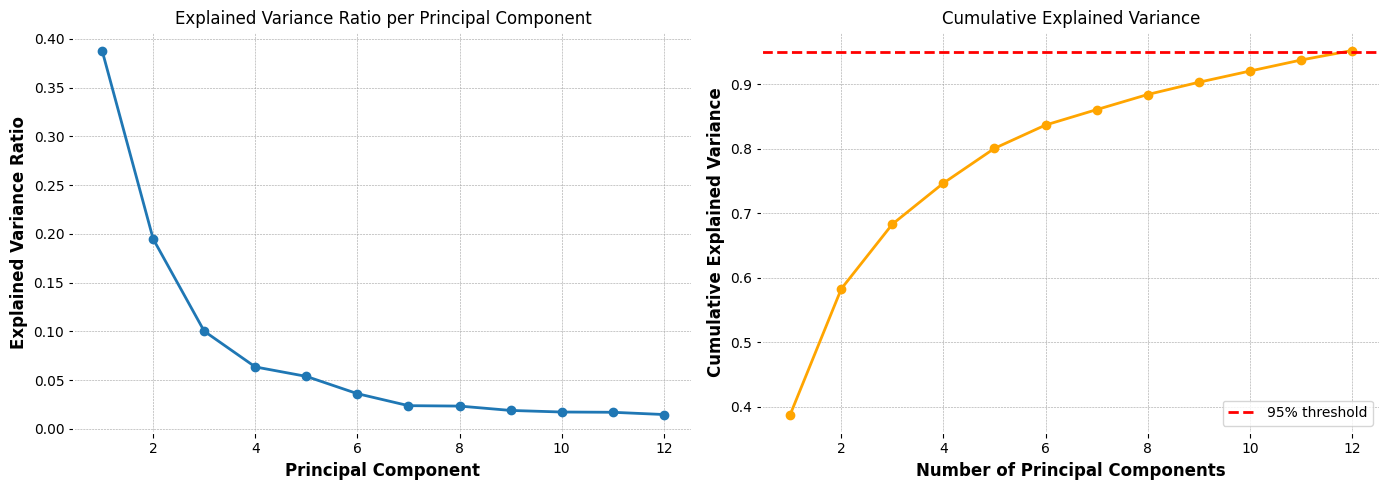

In [60]:
dataloader = CryptoDatasetLoader(
    df_feat,
    target_col="Close",
    scale=True,
    apply_pca=True,
    pca_variance=0.95,
    subset_size=100000   # only use last 100000 rows
)

dataloader.create_target().filter_nulls()
X_train, X_test, y_train, y_test = dataloader.train_test_split()

dataloader.visualise_pca()

# Train Random Forest

In [61]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(
    n_estimators=100,    # fewer trees for a quick test
    max_depth=10,         # shallower trees, faster
    random_state=42,
    n_jobs=-1,           # use all CPU cores
    verbose=1            # prints minimal progress info
)

# Train on the small subset
rf_model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   17.2s finished


,n_estimators,100
,criterion,'squared_error'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


# Evaluation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import polars as pl
from typing import Optional, List
import pandas as pd

class ModelEvaluator:
    """
    A utility class to evaluate regression models with detailed metrics, plots,
    and residual analysis over time.

    Features:
    ----------
    1. Prediction on test data
    2. RMSE and R² metrics computation
    3. Feature importance plotting (if model supports)
    4. Residual analysis: residuals vs predicted, actual vs predicted
    5. Residuals over time (requires timestamp column in dataframe)
    """
    def __init__(self, model, X_test: np.ndarray, y_test: np.ndarray, 
                 df: Optional[pl.DataFrame] = None, timestamp_col: str = "Timestamp",
                 feature_names: Optional[List[str]] = None):
        """
        Initialize the evaluator.

        Parameters:
        -----------
        model : object
            Trained regression model (must support predict method)
        X_test : np.ndarray
            Test features
        y_test : np.ndarray
            True target values for test set
        df : pl.DataFrame, optional
            Original dataset with timestamp column for time-based residuals
        timestamp_col : str
            Name of timestamp column in df (used for residuals over time)
        feature_names : List[str], optional
            Names of features (used for feature importance plot)
        """
        self.model = model
        self.X_test = X_test
        self.y_test = y_test
        self.df = df
        self.timestamp_col = timestamp_col
        self.feature_names = feature_names
        self.y_pred = None  # predictions will be stored here
        self.residuals = None  # residuals = y_test - y_pred

    # ------------------------
    # 1. Make predictions
    # ------------------------
    def predict(self):
        """
        Predict target values on the test set and compute residuals.

        Returns:
        --------
        np.ndarray
            Predicted values
        """
        self.y_pred = self.model.predict(self.X_test)
        self.residuals = self.y_test - self.y_pred
        return self.y_pred

    # ------------------------
    # 2. Compute RMSE and R²
    # ------------------------
    def compute_metrics(self):
        """
        Compute regression evaluation metrics:
        - RMSE: Root Mean Squared Error
        - R²: Coefficient of Determination

        Returns:
        --------
        tuple(float, float)
            RMSE, R²
        """
        if self.y_pred is None:
            self.predict()

        rmse = np.sqrt(mean_squared_error(self.y_test, self.y_pred))
        r2 = r2_score(self.y_test, self.y_pred)
        print(f"RMSE: {rmse:.4f}")
        print(f"R²: {r2:.4f}")
        return rmse, r2

    # ------------------------
    # 3. Plot feature importance
    # ------------------------
    def plot_feature_importance(self, top_n: Optional[int] = None):
        """
        Plot feature importances from the model.

        Parameters:
        -----------
        top_n : int, optional
            Plot only top N features by importance

        Notes:
        ------
        Requires model to have `feature_importances_` attribute.
        Uses provided `feature_names` or defaults to F0, F1, ...
        """
        if hasattr(self.model, "feature_importances_"):
            importances = self.model.feature_importances_

            # Use provided feature names or default F0, F1, ...
            if self.feature_names is None:
                self.feature_names = [f"F{i}" for i in range(len(importances))]

            # Sort features by importance descending
            indices = np.argsort(importances)[::-1]
            sorted_importances = importances[indices]
            sorted_features = [self.feature_names[i] for i in indices]

            # Optionally, only plot top N
            if top_n:
                sorted_importances = sorted_importances[:top_n]
                sorted_features = sorted_features[:top_n]

            plt.figure(figsize=(12,6))
            plt.bar(range(len(sorted_importances)), sorted_importances)
            plt.xticks(range(len(sorted_importances)), sorted_features, rotation=90)
            plt.xlabel("Feature")
            plt.ylabel("Importance")
            plt.title("Feature Importances")
            plt.tight_layout()
            plt.show()
        else:
            print("Model does not have `feature_importances_` attribute.")

    # ------------------------
    # 4. Residual plots
    # ------------------------
    def plot_residuals(self):
        """
        Plot residuals vs predicted values and actual vs predicted.

        - Left: Residuals vs Predicted
            Helps identify non-linearity, heteroscedasticity, or bias
        - Right: Actual vs Predicted
            Shows overall model fit
        """
        if self.y_pred is None:
            self.predict()

        plt.figure(figsize=(12,5))

        # Residuals vs Predicted
        plt.subplot(1,2,1)
        plt.scatter(self.y_pred, self.residuals, alpha=0.5, color='teal')
        plt.axhline(0, color='red', linestyle='--')
        plt.xlabel("Predicted")
        plt.ylabel("Residuals")
        plt.title("Residuals vs Predicted")

        # Actual vs Predicted
        plt.subplot(1,2,2)
        plt.scatter(self.y_test, self.y_pred, alpha=0.5, color='orange')
        plt.plot([self.y_test.min(), self.y_test.max()],
                 [self.y_test.min(), self.y_test.max()],
                 'r--', linewidth=2)
        plt.xlabel("Actual")
        plt.ylabel("Predicted")
        plt.title("Actual vs Predicted")

        plt.tight_layout()
        plt.show()

    # ------------------------
    # 5. Residuals over time
    # ------------------------
    def plot_residuals_over_time(self):
        """
        Plot residuals over time if timestamp column and dataframe are provided.

        Notes:
        ------
        - df must be provided and contain timestamp column
        - Automatically converts timestamp to datetime
        """
        if self.df is None or self.timestamp_col not in self.df.columns:
            print("DataFrame with timestamp column required for this plot.")
            return

        if self.y_pred is None:
            self.predict()

        # Use last N rows corresponding to test set length
        df_subset = self.df.tail(len(self.y_pred)).select([self.timestamp_col]).to_pandas()
        # Convert epoch seconds or milliseconds to datetime
        df_subset[self.timestamp_col] = pd.to_datetime(df_subset[self.timestamp_col] * 1000, unit='ms')

        plt.figure(figsize=(15,5))
        plt.plot(df_subset[self.timestamp_col], self.residuals, label="Residuals", color="teal")
        plt.axhline(0, color='red', linestyle='--')
        plt.xlabel("Time")
        plt.ylabel("Residuals")
        plt.title("Residuals over Time")
        plt.legend()
        plt.show()


RMSE: 0.0570
R²: 0.9710


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


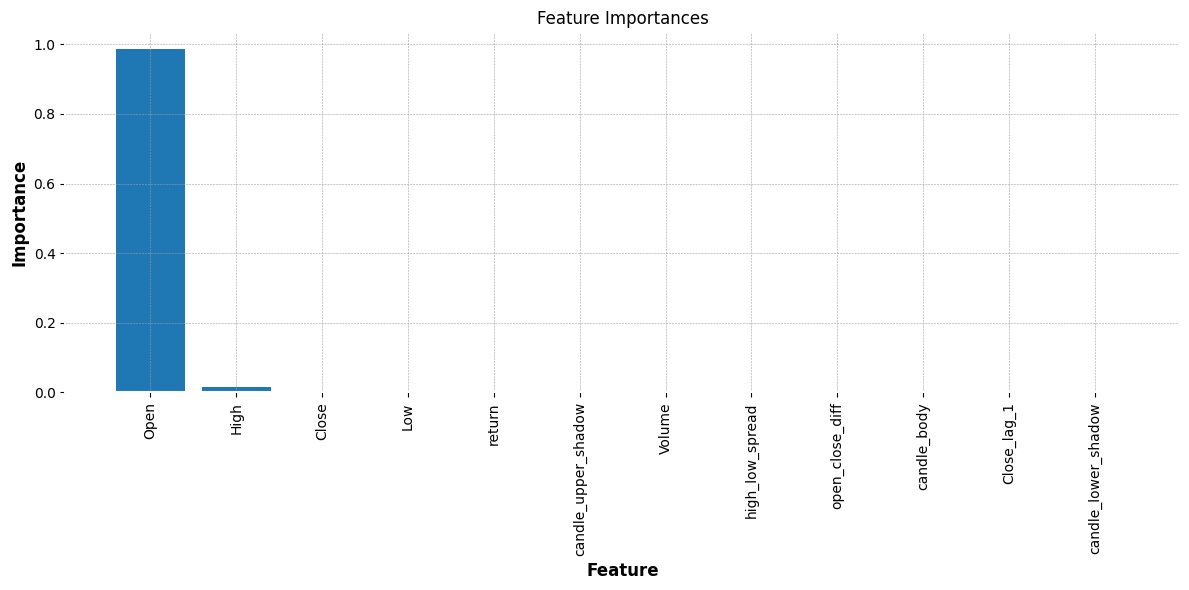

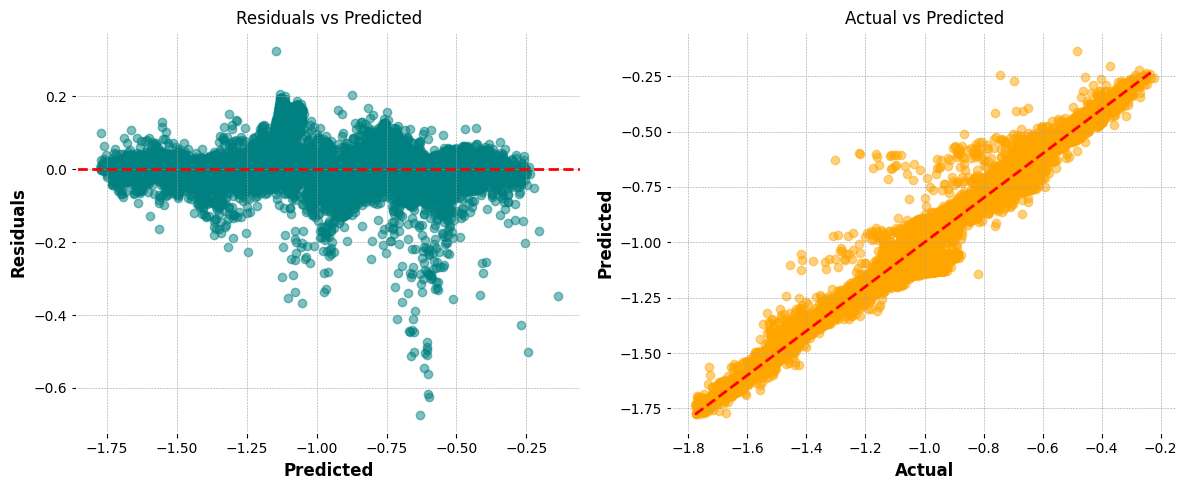

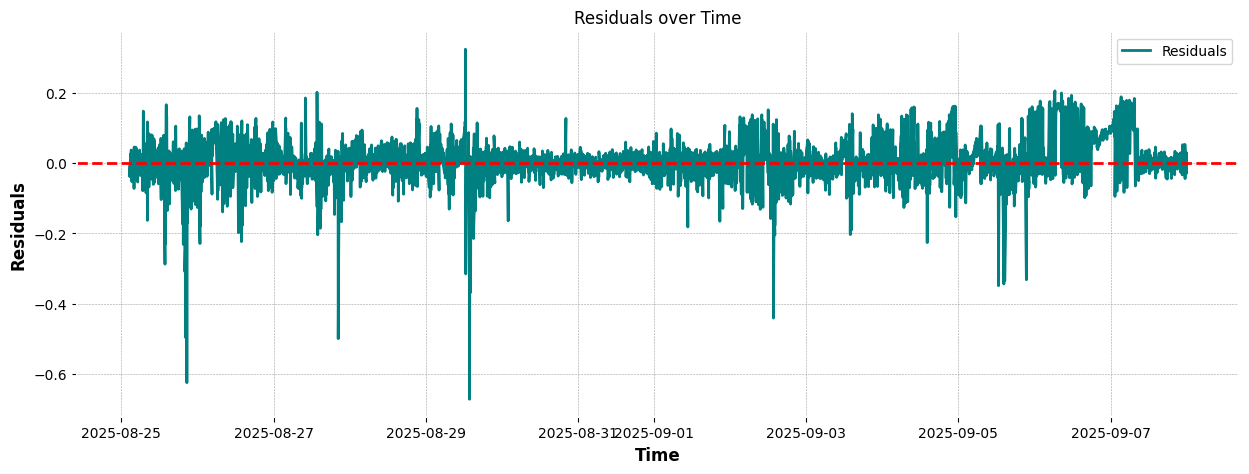

In [63]:
# Pass feature names from your dataset or PCA columns
feature_cols = [col for col in df_feat.columns if col not in ["Timestamp", "target"]]

evaluator = ModelEvaluator(
    model=rf_model,
    X_test=X_test,
    y_test=y_test,
    df=df,
    timestamp_col="Timestamp",
    feature_names=feature_cols
)

evaluator.predict()
evaluator.compute_metrics()
evaluator.plot_feature_importance(top_n=20)
evaluator.plot_residuals()
evaluator.plot_residuals_over_time()
